## Background

Unlike [Issue-Label Bot](https://github.com/marketplace/issue-label-bot) which predicts generic `bug`, `feature-request` and `question` labels, we are attempting to build the capability to predict repo-specific labels.  One of the primary challenges of doing this is a dearth of labeled examples for a particular repo.  Therefore, we attempt to generate features via transfer learning from a language model trained over a large corpus of GitHub issues.  These features are then fed downstream to a classifier with the goal of enabling the classifier to predict personalized issue labels based upon existing hand-labeled issues present in a repository.  

As an initial test, we will evaluate the ability to predict `sig/` labels on the [Kubernetes/Kubernetes](https://github.com/kubernetes/kubernetes) repo.  

In order to measure the efficacy of these embeddings, we will use [DataRobot](https://www.datarobot.com/) as a benchmark to see if adding embeddings from transfer learning improves model performance relative to TFIDF n-gram techniques featurization of text.  

#### SQL Query In [BigQuery](https://console.cloud.google.com/bigquery?sq=1073071082706:e0106dd7b95a4acaabe5ee94d8bffdf9)

```sql

#standardSQL

SELECT *
FROM (
  SELECT
    updated_at
    , MAX(updated_at) OVER (PARTITION BY url) as last_time
    , FORMAT("%T", ARRAY_CONCAT_AGG(labels)) as labels
    , repo, url, title, body, len_labels
  FROM(
      SELECT
          TIMESTAMP(REGEXP_REPLACE(JSON_EXTRACT(payload, '$.issue.updated_at'), "\"", "")) as updated_at
        , REGEXP_EXTRACT(JSON_EXTRACT(payload, '$.issue.url'), r'https://api.github.com/repos/(.*)/issues') as repo
        , JSON_EXTRACT(payload, '$.issue.url') as url
          -- extract the title and body removing parentheses, brackets, and quotes
        , LOWER(TRIM(REGEXP_REPLACE(JSON_EXTRACT(payload, '$.issue.title'), r"\\n|\(|\)|\[|\]|#|\*|`|\"", ' '))) as title
        , LOWER(TRIM(REGEXP_REPLACE(JSON_EXTRACT(payload, '$.issue.body'), r"\\n|\(|\)|\[|\]|#|\*|`|\"", ' '))) as body
        , REGEXP_EXTRACT_ALL(JSON_EXTRACT(payload, "$.issue.labels"), ',"name\":"(.+?)","color') as labels
        , ARRAY_LENGTH(REGEXP_EXTRACT_ALL(JSON_EXTRACT(payload, "$.issue.labels"), ',"name\":"(.+?)","color')) as len_labels
      FROM `githubarchive.month.20*`
      WHERE 
          _TABLE_SUFFIX BETWEEN '1601' and '1912'
          and type="IssuesEvent"
  )
  WHERE 
    repo = 'kubernetes/kubernetes'
  GROUP BY updated_at, repo, url, title, body, len_labels
)
WHERE last_time = updated_at and len_labels >= 1
```

#### The results of the above query can be downloaded as a csv file from this link: 

https://storage.googleapis.com/issue_label_bot/k8s_issues/000000000000.csv

In [35]:
import pandas as pd
import numpy as np
from random import randint
from matplotlib import pyplot as plt
import re
pd.set_option('max_colwidth', 1000)

In [36]:
df = pd.read_csv('https://storage.googleapis.com/issue_label_bot/k8s_issues/000000000000.csv')
df.labels = df.labels.apply(lambda x: eval(x))
df.head()

,updated_at,last_time,labels,repo,url,title,body,len_labels
0,2018-02-24 15:09:51 UTC,2018-02-24 15:09:51 UTC,"[lifecycle/rotten, priority/backlog, sig/cluster-lifecycle, sig/node]",kubernetes/kubernetes,"""https://api.github.com/repos/kubernetes/kubernetes/issues/16512""",minions ip does not follow --hostname-override when set to a hostname,"according to 9267, the kubelet should register a node with the --hostname-override cluster from scratch . this does not work if set to an actual hostname even one that resolves correctly . working with the ip: sh $ /opt/bin/kubelet --hostname-override=172.16.25.131 --address=172.16.25.131 ... $ kubectl describe node minion-2 name: minion-2 ... addresses: 172.16.25.131 and when the override is set to a hostname which resolves to the 172 ip : $ /opt/bin/kubelet --hostname-override=my-server.com --address=172.16.25.131 ... $ kubectl describe node minion-2 name: minion-2 ... addresses: 2a01:4f8:110:4085::2",4
1,2016-03-01 00:30:05 UTC,2016-03-01 00:30:05 UTC,"[kind/flake, priority/P1, team/control-plane, kind/flake, priority/P1, team/control-plane]",kubernetes/kubernetes,"""https://api.github.com/repos/kubernetes/kubernetes/issues/16623""",e2e flake: daemon set should run and stop complex daemon,"this has been flaking pretty often lately - in 5 out of the last 11 runs of kubernetes-e2e-gce-flaky, to be specific. i've copied the output of one such failure run below.\r \r sorry if there's already an issue tracking this, i couldn't find anything other than 14072, which is for a different test.\r \r @mikedanese \r \r \r 14:35:47 daemon set \r 14:35:47 should run and stop complex daemon\r 14:35:47 /go/src/k8s.io/kubernetes/_output/dockerized/go/src/k8s.io/kubernetes/test/e2e/daemon_set.go:181\r 14:35:47 beforeeach daemon set\r 14:35:47 /go/src/k8s.io/kubernetes/_output/dockerized/go/src/k8s.io/kubernetes/test/e2e/framework.go:51\r 14:35:47 step: creating a kubernetes client\r 14:35:47 >>> testcontext.kubeconfig: /var/lib/jenkins/jobs/kubernetes-e2e-gce-flaky/workspace/.kube/config\r 14:35:47 step: building a namespace api object\r 14:35:47 oct 30 14:35:47.266: info: waiting up to 2m0s for service account default to be provisioned in ns e2e-tests-daemonsets-40nfz\r 14...",3
2,2016-02-19 18:55:16 UTC,2016-02-19 18:55:16 UTC,"[area/usability, component/kubectl, kind/enhancement, priority/P2, team/ux]",kubernetes/kubernetes,"""https://api.github.com/repos/kubernetes/kubernetes/issues/20078""",can't abort kubectl edit,"i am running kubectl edit against an object. i make a mistake, and it reopens nice with comments nice . i decide i don't want to edit, after all. how do i abort? in most scenarios, exiting without save or deleting all contents would trigger the process to abort. not so in kubectl.",5
3,2016-02-25 00:27:07 UTC,2016-02-25 00:27:07 UTC,"[area/test, kind/flake, priority/P1, team/control-plane]",kubernetes/kubernetes,"""https://api.github.com/repos/kubernetes/kubernetes/issues/21234""",e2e flake: limitrange it should create a limitrange with defaults and ensure pod has those defaults applied.,"limitrange e2e flake:\r \r \r failure 7.616 seconds \r limitrange\r /go/src/k8s.io/kubernetes/_output/dockerized/go/src/k8s.io/kubernetes/test/e2e/limit_range.go:95\r should create a limitrange with defaults and ensure pod has those defaults applied. it \r /go/src/k8s.io/kubernetes/_output/dockerized/go/src/k8s.io/kubernetes/test/e2e/limit_range.go:93\r \r expected error:\r < errors.errorstring | 0xc20853e960>: {\r s: \ resource cpu expected 100m actual 0\ ,\r }\r resource cpu expected 100m actual 0\r not to have occurred\r \r /go/src/k8s.io/kubernetes/_output/dockerized/go/src/k8s.io/kubernetes/test/e2e/limit_range.go:64\r ------------------------------\r \r \r https://console.developers.google.com/storage/browser/kubernetes-jenkins/pr-logs/pull/20114/kubernetes-pull-build-test-e2e-gce/28527/",4
4,2016-06-14 04:14:18 UTC,2016-06-14 04:14:18 UTC,[],kubernetes/kubernetes,"""https://api.github.com/repos/k

In [37]:
#remove target leakage from kubernetes which are the bot commands
df['body'] = df.body.apply(lambda x: re.sub('(/sig|/kind|/status/triage/|priority) \S+', '', str(x)))

# Explore The Data

### Question from @cblecker

`@Hamel Husain that's how often a PR/issue has two different sig labels on it?`

In [38]:
def count_sig(l):
    return(sum(['sig/' in x for x in l]))

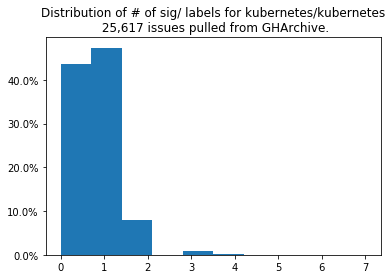

In [39]:
from matplotlib.ticker import PercentFormatter
sig_counts = df.labels.apply(lambda x: count_sig(x))

plt.hist(sig_counts, weights=np.ones(len(sig_counts)) / len(sig_counts))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title(f'Distribution of # of sig/ labels for kubernetes/kubernetes\n {len(sig_counts):,} issues pulled from GHArchive.')
plt.show()

### Count Labels

In [40]:
from collections import Counter
c = Counter()

for row in df.labels:
    c.update(row)

In [41]:
print(f'There are {len(c.keys())} unique labels in kubernetes/kubernetes')
nsig = sum(['sig/' in x for x in list(c.keys())])
print(f"number of sig labels: {nsig}")

There are 280 unique labels in kubernetes/kubernetes
number of sig labels: 34


#### Top 50 Labels

In [74]:
c.most_common(50)

[('kind/bug', 6107),
 ('lifecycle/rotten', 4352),
 ('kind/flake', 3294),
 ('sig/node', 2738),
 ('sig/api-machinery', 2228),
 ('kind/feature', 2051),
 ('sig/network', 1829),
 ('priority/P2', 1821),
 ('sig/storage', 1596),
 ('priority/backlog', 1588),
 ('priority/P1', 1418),
 ('priority/important-soon', 1222),
 ('needs-sig', 1188),
 ('team/test-infra', 1158),
 ('sig/cli', 1109),
 ('sig/cluster-lifecycle', 950),
 ('team/cluster', 915),
 ('priority/P0', 903),
 ('sig/apps', 844),
 ('team/node', 836),
 ('team/control-plane', 810),
 ('sig/scheduling', 798),
 ('lifecycle/stale', 784),
 ('area/test', 783),
 ('team/ux', 733),
 ('sig/testing', 715),
 ('team/cluster (deprecated - do not use)', 706),
 ('area/kubectl', 678),
 ('sig/auth', 600),
 ('component/kubectl', 563),
 ('priority/critical-urgent', 553),
 ('sig/scalability', 511),
 ('kind/documentation', 483),
 ('team/control-plane (deprecated - do not use)', 451),
 ('kind/cleanup', 438),
 ('sig/aws', 438),
 ('team/CSI-API Machinery SIG', 430),


In [79]:
len([(k, c[k]) for k in c if c[k] >= 100])

98

#### Sig/ Labels

In [43]:
sig_labels = [x for x in list(c.keys()) if 'sig/' in x]
for l in sig_labels:
    print(f'{l}: {c[l]}')

sig/cluster-lifecycle: 950
sig/node: 2738
sig/api-machinery: 2228
sig/scalability: 511
sig/cli: 1109
sig/autoscaling: 210
sig/network: 1829
sig/cloud-provider: 54
sig/storage: 1596
sig/scheduling: 798
sig/apps: 844
sig/windows: 185
sig/auth: 600
sig/docs: 205
sig/testing: 715
sig/federation: 170
sig/gcp: 203
sig/release: 330
sig/azure: 302
sig/aws: 438
sig/cluster-ops: 63
sig/multicluster: 175
sig/instrumentation: 253
sig/openstack: 151
sig/contributor-experience: 152
sig/architecture: 99
sig/vmware: 39
sig/rktnetes: 14
sig/service-catalog: 33
sig/onprem: 23
sig/ui: 25
sig/big-data: 7
sig/contrib-ex: 1
sig/ibmcloud: 1


#### See correlation among labels 

In [10]:
min_freq = 30

def contains_sig(l):
    if not l:
        return False
    else:
        # make sure there are at least 10 issues labeled with that value
        return max(['sig/' in x and c[x] >=min_freq for x in l])

In [11]:
sig_df = df[df.labels.apply(lambda x: contains_sig(x))]
print(f'{sig_df.shape[0]:,} issues have sig/ labels')

14,390 issues have sig/ labels


In [12]:
sig_labels = [k for k in c.keys() if c[k] >= min_freq and 'sig/' in k]
print(f'{len(sig_labels)} sig labels that have at least {min_freq} issues')

28 sig labels that have at least 30 issues


In [13]:
# build an indicator matrix

indicator = []

for l in sig_df.labels.values:
    zer = np.zeros(len(sig_labels))
    mask = [sig_labels.index(x) for x in l if x in sig_labels]
    zer[mask] = 1
    indicator.append(zer[None, :])
    
indicator_matrix = pd.DataFrame(np.concatenate(indicator, axis=0), columns=sig_labels).astype(int)
corr_grid = indicator_matrix.T.dot(indicator_matrix)

In [14]:
for i, x in enumerate(corr_grid):
    corr_grid.iloc[i][i:] = 0

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
#cmap = sns.diverging_palette(220, 10, as_cmap=True)

In [16]:
#normalize correlation grid
for label in corr_grid:
    corr_grid.loc[label] = corr_grid.loc[label] / c[label]

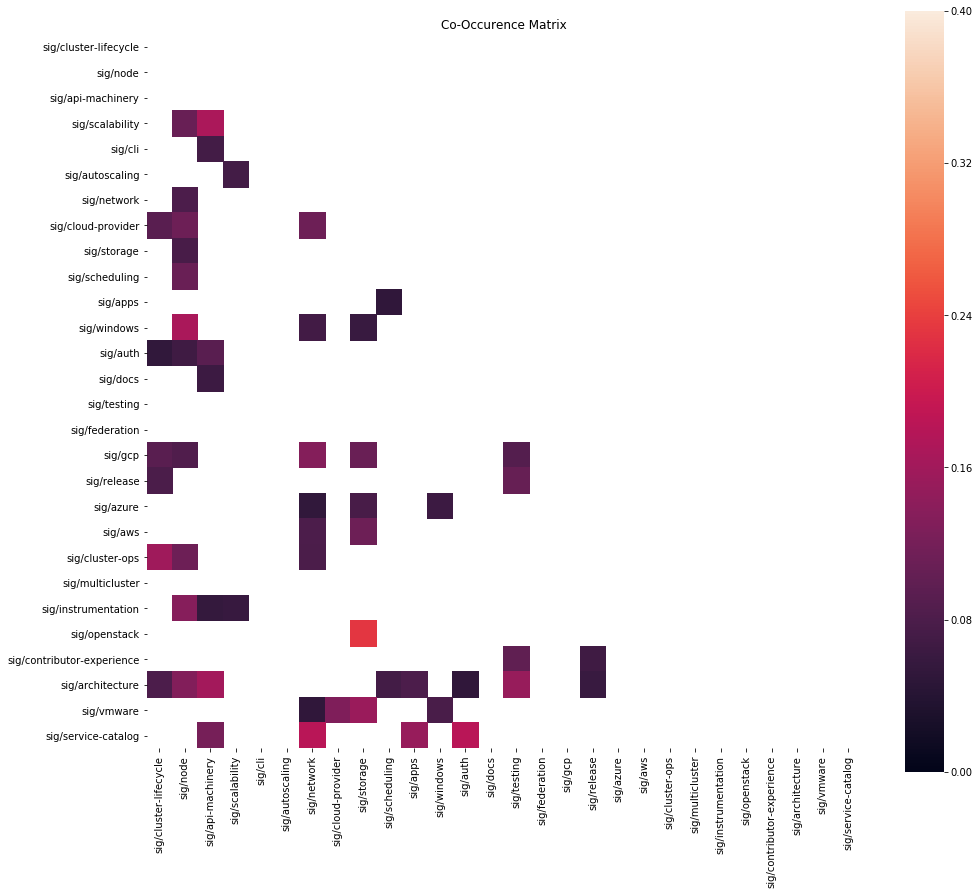

In [17]:
plt.figure(figsize=(16, 14))
plt.title('Co-Occurence Matrix')
sns.heatmap(corr_grid, square=True, vmin=0, vmax=.4, mask=corr_grid<=0.05)

## Obtain Baseline With Automated Machine Learning

In [18]:
def part_assign():
    i = randint(1, 10)
    if i <=5:
        return i
    else:
        return 6

combined_sig_df = pd.concat([sig_df.reset_index(), indicator_matrix.reset_index()], axis=1)
combined_sig_df['part'] = combined_sig_df.repo.apply(lambda x: part_assign())
combined_sig_df.to_pickle('combined_sig_df.pkl')

In [19]:
combined_sig_df = pd.read_pickle('combined_sig_df.pkl')

In [20]:
#! pip install datarobot

In [21]:
import datarobot as dr
from datarobot import UserCV
from fastai.core import parallel
from datarobot import Blueprint

ucv = UserCV(user_partition_col='part', cv_holdout_level=6, seed=123)
dr.Client(token='something-something', endpoint='https://app.datarobot.com/api/v2')

In [22]:
def create_dr_proj(label):
    temp_df = combined_sig_df[['title', 'body', 'part', label]]
    proj = dr.Project.create(sourcedata=temp_df,
                             project_name=label,
                            )
    proj.set_target(label, 
                positive_class=1,
                partitioning_method=ucv,
                target_type='Binary',
                mode=dr.AUTOPILOT_MODE.MANUAL,
                worker_count=9,
                max_wait=600000)
    
    bps = proj.get_blueprints()
    bp = [b for b in bps if 'Nystroem' in str(b)][0]
    proj.train(bp, sample_pct=49.8)
    proj.unlock_holdout()
    
    return proj

In [23]:
proj_list = []

for i, label in enumerate(sig_labels):
    try:
        print(f'creating project {i}: {label}')
        proj = create_dr_proj(label)
        proj_list.append(proj)
    except:
        pass

creating project 0: sig/cluster-lifecycle
creating project 1: sig/node


In [264]:
predictions = []
for proj in proj_list:
    print(f'getting predictions for holdout set for {str(proj)}')
    label = proj.target.replace('_', '-')
    temp_df = combined_sig_df[['title', 'body', 'part', label]]
    temp_df = temp_df[temp_df.part == 6]
    ds = proj.upload_dataset(temp_df)
    m = proj.get_models()[0]
    predict_job = m.request_predictions(ds.id)
    yhat = predict_job.get_result_when_complete()
    predictions.append({label: yhat['positive_probability']})

getting predictions for holdout set for Project(sig/cluster-lifecycle)
getting predictions for holdout set for Project(sig/node)
getting predictions for holdout set for Project(sig/api-machinery)
getting predictions for holdout set for Project(sig/scalability)
getting predictions for holdout set for Project(sig/cli)
getting predictions for holdout set for Project(sig/autoscaling)
getting predictions for holdout set for Project(sig/network)
getting predictions for holdout set for Project(sig/cloud-provider)
getting predictions for holdout set for Project(sig/storage)
getting predictions for holdout set for Project(sig/scheduling)
getting predictions for holdout set for Project(sig/windows)
getting predictions for holdout set for Project(sig/auth)
getting predictions for holdout set for Project(sig/docs)
getting predictions for holdout set for Project(sig/testing)
getting predictions for holdout set for Project(sig/federation)
getting predictions for holdout set for Project(sig/gcp)
gett

In [287]:
result = {}
for d in predictions:
    result.update(d)

baseline_holdout_predictions_df = pd.DataFrame(result)
baseline_holdout_predictions_df.columns = ['p_'+x for x in baseline_holdout_predictions_df.columns]

In [282]:
assert len(baseline_holdout_predictions_df) == len(combined_sig_df[combined_sig_df.part == 6])

In [298]:
predictions_df = pd.concat([combined_sig_df[combined_sig_df.part == 6].reset_index(drop=True), 
                               baseline_holdout_predictions_df.reset_index(drop=True)], axis=1)
predictions_df['version'] = 'baseline'

In [299]:
predictions_df.to_pickle('prediction_baseline_df.pkl')

# Get Embeddings and Repeat

In [81]:
import pandas as pd
from inference import InferenceWrapper, pass_through
import os
import torch
from torch.cuda import empty_cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

wrapper = InferenceWrapper(model_path='/ds/lang_model/models_uxgcl1e1/',
                           model_file_name='trained_model_uxgcl1e1.pkl')

empty_cache()

In [2]:
combined_sig_df = pd.read_pickle('combined_sig_df.pkl')
# text = wrapper.process_df(combined_sig_df)
# text.to_pickle('textlm_df.pkl')

/ds/notebooks/inference.py:62: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  for d in tqdm(dataframe.to_dict(orient='rows')):


In [4]:
text = pd.read_pickle('textlm_df.pkl')
assert text['text'].isna().sum() == 0

In [5]:
features = []

In [6]:
from tqdm.auto import tqdm

with torch.no_grad():
    for t in tqdm(text['text'].values):
        feat = wrapper.get_pooled_features(t).cpu()
        features.append(feat)
        empty_cache()

In [7]:
feat_matrix = torch.cat(features, dim=0).numpy()

In [26]:
feat_matrix = feat_matrix[:, :1600]

In [27]:
feat_df = pd.DataFrame(feat_matrix)
feat_df.columns = ['f_' + str(x) for x in feat_df.columns]
feat_df.to_csv('feat_df.csv', index=False)

In [28]:
feat_df = pd.read_csv('feat_df.csv')

In [29]:
lm_combined_df = pd.concat([combined_sig_df.reset_index(drop=True), 
                            feat_df.reset_index(drop=True)], axis=1)

In [30]:
import datarobot as dr
from datarobot import UserCV
ucv = UserCV(user_partition_col='part', cv_holdout_level=6, seed=123)
dr.Client(token='something', endpoint='https://app.datarobot.com/api/v2')

def create_dr_proj(label):
    temp_df = lm_combined_df[['title', 'body', 'part', label] + list(feat_df.columns)]
    proj = dr.Project.create(sourcedata=temp_df,
                             project_name='lm_'+label,
                            )
    proj.set_target(label, 
                    positive_class=1,
                    partitioning_method=ucv,
                    target_type='Binary',
                    mode=dr.AUTOPILOT_MODE.QUICK,
                    worker_count=9,
                    max_wait=600000)
    
    proj.unlock_holdout()
    
    return proj

In [31]:
proj_list_lm = []

for i, label in enumerate(sig_labels):
    try:
        print(f'creating project {i}: lm_{label}')
        proj = create_dr_proj(label)
        proj_list_lm.append(proj)
    except:
        pass

creating project 0: lm_sig/cluster-lifecycle
creating project 1: lm_sig/node
creating project 2: lm_sig/api-machinery
creating project 3: lm_sig/scalability
creating project 4: lm_sig/cli
creating project 5: lm_sig/autoscaling
creating project 6: lm_sig/network
creating project 7: lm_sig/cloud-provider
creating project 8: lm_sig/storage
creating project 9: lm_sig/scheduling
creating project 10: lm_sig/apps
creating project 11: lm_sig/windows
creating project 12: lm_sig/auth
creating project 13: lm_sig/docs
creating project 14: lm_sig/testing
creating project 15: lm_sig/federation
creating project 16: lm_sig/gcp
creating project 17: lm_sig/release
creating project 18: lm_sig/azure
creating project 19: lm_sig/aws
creating project 20: lm_sig/cluster-ops
creating project 21: lm_sig/multicluster
creating project 22: lm_sig/instrumentation
creating project 23: lm_sig/openstack
creating project 24: lm_sig/contributor-experience
creating project 25: lm_sig/architecture
creating project 26: lm_

# Compare Transfer Learning vs. Regular Methods 

In [1]:
import datarobot as dr
from datarobot import UserCV
dr.Client(token='something-something', endpoint='https://app.datarobot.com/api/v2')

def get_metrics(modelobj):
    return modelobj.metrics['AUC']['holdout']

In [2]:
projects = [p for p in dr.Project.list() if p.project_name.startswith('lm_')]

In [44]:
'hamel'.replace('am', 'gg')

'hggel'

In [45]:
label = []
category = []
auc = []

for proj in projects:
    print(f'getting metrics for {proj.project_name}')
    models = [m for m in proj.get_models() if m.sample_pct > 45]
    baseline_model = sorted([m for m in models if m.featurelist_name == 'text only'], key=get_metrics, reverse=True)[0]
    deep_model = sorted([m for m in models if m.featurelist_name != 'text only'], key=get_metrics, reverse=True)[0]
    baseline_auc = get_metrics(baseline_model)
    deep_auc = get_metrics(deep_model)
    label.extend([proj.project_name.replace('lm_', '')] * 2)
    category.extend(['baseline', 'deep'])
    auc.extend([baseline_auc, deep_auc])

getting metrics for lm_sig/vmware
getting metrics for lm_sig/architecture
getting metrics for lm_sig/contributor-experience
getting metrics for lm_sig/openstack
getting metrics for lm_sig/instrumentation
getting metrics for lm_sig/multicluster
getting metrics for lm_sig/cluster-ops
getting metrics for lm_sig/aws
getting metrics for lm_sig/azure
getting metrics for lm_sig/release
getting metrics for lm_sig/gcp
getting metrics for lm_sig/federation
getting metrics for lm_sig/testing
getting metrics for lm_sig/docs
getting metrics for lm_sig/auth
getting metrics for lm_sig/windows
getting metrics for lm_sig/apps
getting metrics for lm_sig/scheduling
getting metrics for lm_sig/storage
getting metrics for lm_sig/cloud-provider
getting metrics for lm_sig/network
getting metrics for lm_sig/autoscaling
getting metrics for lm_sig/cli
getting metrics for lm_sig/scalability
getting metrics for lm_sig/api-machinery
getting metrics for lm_sig/node
getting metrics for lm_sig/cluster-lifecycle


In [46]:
import pandas as pd
compare_df = pd.DataFrame({'label': label, 
                          'category': category,
                          'auc': auc})

In [73]:
pivot = compare_df.pivot(index='label', columns='category', values='auc')
pivot['winner'] = pivot.apply(lambda x: 'deep' if x.deep > x.baseline else 'baseline', axis=1)
pivot['abs diff'] = pivot.apply(lambda x: abs(x.deep - x.baseline), axis=1)
pivot['label count'] = [c[x] for x in pivot.index.values]
pivot.sort_values(by=['label count'], ascending=False)

category,baseline,deep,winner,abs diff,label count
label,,,,,
sig/node,0.91357,0.91581,deep,0.00224,2738
sig/api-machinery,0.91833,0.92121,deep,0.00288,2228
sig/network,0.95846,0.96263,deep,0.00417,1829
sig/storage,0.97308,0.97626,deep,0.00318,1596
sig/cli,0.95712,0.95872,deep,0.00160,1109
sig/cluster-lifecycle,0.90756,0.90328,baseline,0.00428,950
sig/apps,0.93730,0.93157,baseline,0.00573,844
sig/scheduling,0.94497,0.94750,deep,0.00253,798
sig/testing,0.92759,0.92639,baseline,0.00120,715


In [80]:
wrapper

NameError: name 'wrapper' is not defined

In [99]:
len(wrapper.learn.data.vocab.itos)

60000

In [100]:
pivot.to_picklei('pivot_df.pkl')

category,baseline,deep,winner,abs diff,label count
label,,,,,
sig/api-machinery,0.91833,0.92121,deep,0.00288,2228
sig/apps,0.93730,0.93157,baseline,0.00573,844
sig/architecture,0.77077,0.79016,deep,0.01939,99
sig/auth,0.96020,0.96989,deep,0.00969,600
sig/autoscaling,0.98215,0.97122,baseline,0.01093,210
sig/aws,0.96803,0.96946,deep,0.00143,438
sig/azure,0.98287,0.97849,baseline,0.00438,302
sig/cli,0.95712,0.95872,deep,0.00160,1109
sig/cloud-provider,0.94083,0.83947,baseline,0.10136,54


In [103]:
import pandas as pd

In [116]:
score_df = pd.read_pickle('score_df.pkl')

In [117]:
score_df.set_index('label', inplace=True)

In [118]:
score_df.columns = ['deep2']

In [119]:
new_pivot = pivot.join(score_df, how='left')[['baseline', 'deep', 'deep2', 'label count']]

In [121]:
def winner(x):
    if x.baseline > x.deep and x.baseline > x.deep2:
        return 'baseline'
    elif x.deep > x.deep2:
        return 'deep'
    elif x.deep2 > x.deep:
        return 'deep2'

In [124]:
new_pivot.dropna(inplace=True)

In [125]:
new_pivot['winner'] = new_pivot.apply(lambda x: winner(x), axis=1)

In [130]:
new_pivot['baseline minus best deep'] = new_pivot.apply(lambda x: x.baseline - max(x.deep, x.deep2), axis=1)

In [135]:
new_pivot['abs diff'] = new_pivot.apply(lambda x: abs(x['baseline minus best deep']), axis=1)

In [136]:
new_pivot.sort_values('label count', ascending=False)

,baseline,deep,deep2,label count,winner,baseline minus best deep,abs diff
label,,,,,,,
sig/node,0.91357,0.91581,0.858869,2738,deep,-0.002240,0.002240
sig/api-machinery,0.91833,0.92121,0.885092,2228,deep,-0.002880,0.002880
sig/network,0.95846,0.96263,0.923890,1829,deep,-0.004170,0.004170
sig/storage,0.97308,0.97626,0.950718,1596,deep,-0.003180,0.003180
sig/cli,0.95712,0.95872,0.931973,1109,deep,-0.001600,0.001600
sig/cluster-lifecycle,0.90756,0.90328,0.839113,950,baseline,0.004280,0.004280
sig/apps,0.93730,0.93157,0.870553,844,baseline,0.005730,0.005730
sig/scheduling,0.94497,0.94750,0.919081,798,deep,-0.002530,0.002530
sig/testing,0.92759,0.92639,0.891095,715,baseline,0.001200,0.001200


In [132]:
new_pivot.mean()

baseline                      0.941500
deep                          0.936774
deep2                         0.918506
label count                 694.791667
baseline minus best deep     -0.001628
dtype: float64